# SENTDEX

## Dependencies

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym import wrappers
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt

## HyperParameters

In [79]:
learning_rate = 0.1
discount = 0.95
episodes = 25000
show_every = 500

In [80]:
epsilon = 0.5
start_epsilon_decaying = 1
end_epsilon_decaying = episodes // 2

epsilon_decay_value = epsilon/(end_epsilon_decaying - start_epsilon_decaying)

### Initializing the env

In [81]:
env = gym.make('CartPole-v1')
observation = env.reset()
observation

array([ 0.00302347, -0.00851478,  0.01153003, -0.00482404])

In [82]:
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.n)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
2


### initializing q table

In [83]:
discrete_os_size = [20]*len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/discrete_os_size

D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in subtract
  


In [84]:
q_table = np.random.uniform(low=-2, high=0, size=(discrete_os_size + [env.action_space.n]))

ep_rewards = []
agg_ep_rewards = {'epi':[], 'avg':[], 'min':[], 'max':[] }

## Continous to descrete states

In [85]:
def get_discrete_state(state):
    discrete = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete.astype(np.int))

## Training

In [86]:
c=0
for episode in range(episodes):
    episode_reward = 0
    if episode % show_every == 0:
        render = True
    else:
        render = False
    
    discrete_state = get_discrete_state(env.reset())
    done = False
    while not done:
        
        if np.random.random() > epsilon:
            action = np.argmax(q_table[discrete_state])
        else:
            action = np.random.randint(0, env.action_space.n)
        new_state, reward, done, info = env.step(action)

        episode_reward += reward
        new_discrete_state = get_discrete_state(new_state)
        
        c += 1
        
        if render:
            env.render()

        if not done:
            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action,)]

            new_q = (1 - learning_rate) * current_q + learning_rate * (reward + discount * max_future_q)
            q_table[discrete_state + (action,)] = new_q

        elif c >= 200:
            if episode%1000 == 0:
                print('won at episode = ', episode)
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state
    if end_epsilon_decaying >= episode >= start_epsilon_decaying:
        epsilon -= epsilon_decay_value
    
    ep_rewards.append(episode_reward)
    
    if episode % 20 == 0:
        np.save(f'qtables/{episode}-qtable.npy', q_table)
    
    if episode % show_every == 0:
        average_reward = sum(ep_rewards[-show_every:])/len(ep_rewards[-show_every:])
        agg_ep_rewards['epi'].append(episode)
        agg_ep_rewards['avg'].append(average_reward)
        agg_ep_rewards['min'].append(min(ep_rewards[-show_every:]))
        agg_ep_rewards['max'].append(max(ep_rewards[-show_every:]))

        print(f'Episode: {episode}    Average: {average_reward}  Min: {min(ep_rewards[-show_every:])}  Max: {max(ep_rewards[-show_every:])}')
    
env.close()

Episode: 0    Average: 11.0  Min: 11.0  Max: 11.0
Episode: 500    Average: 22.26  Min: 8.0  Max: 81.0
won at episode =  1000
Episode: 1000    Average: 23.506  Min: 8.0  Max: 100.0
Episode: 1500    Average: 22.016  Min: 8.0  Max: 93.0
won at episode =  2000
Episode: 2000    Average: 22.6  Min: 8.0  Max: 100.0
Episode: 2500    Average: 23.072  Min: 8.0  Max: 84.0
won at episode =  3000
Episode: 3000    Average: 25.27  Min: 8.0  Max: 101.0
Episode: 3500    Average: 24.41  Min: 8.0  Max: 101.0
won at episode =  4000
Episode: 4000    Average: 23.7  Min: 8.0  Max: 104.0
Episode: 4500    Average: 23.64  Min: 8.0  Max: 116.0
won at episode =  5000
Episode: 5000    Average: 24.974  Min: 8.0  Max: 93.0
Episode: 5500    Average: 24.492  Min: 8.0  Max: 102.0
won at episode =  6000
Episode: 6000    Average: 26.208  Min: 8.0  Max: 94.0
Episode: 6500    Average: 24.092  Min: 8.0  Max: 104.0
won at episode =  7000
Episode: 7000    Average: 23.412  Min: 8.0  Max: 80.0
Episode: 7500    Average: 25.004  

In [64]:
env.close()

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

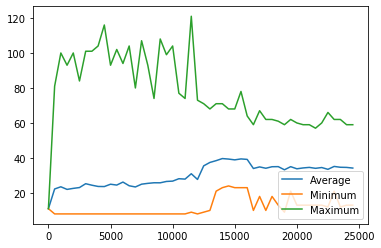

In [87]:
plt.plot(agg_ep_rewards['epi'], agg_ep_rewards['avg'], label='Average')
plt.plot(agg_ep_rewards['epi'], agg_ep_rewards['min'], label='Minimum')
plt.plot(agg_ep_rewards['epi'], agg_ep_rewards['max'], label='Maximum')
plt.legend(loc=4)
plt.plot

# Using the Q table

In [70]:
env.reset()

array([-0.00953316,  0.01908747, -0.04695336, -0.04669776])

In [76]:
q_table = np.load(f"qtables/15000-qtable.npy")
discrete_state = get_discrete_state(env.reset())
done = False
while not done:
    
    env.render()
    action = np.argmax(q_table[discrete_state])
    new_state, reward, done, info = env.step(action)
    discrete_state = get_discrete_state(new_state)
env.close()

# Plotting Q_table

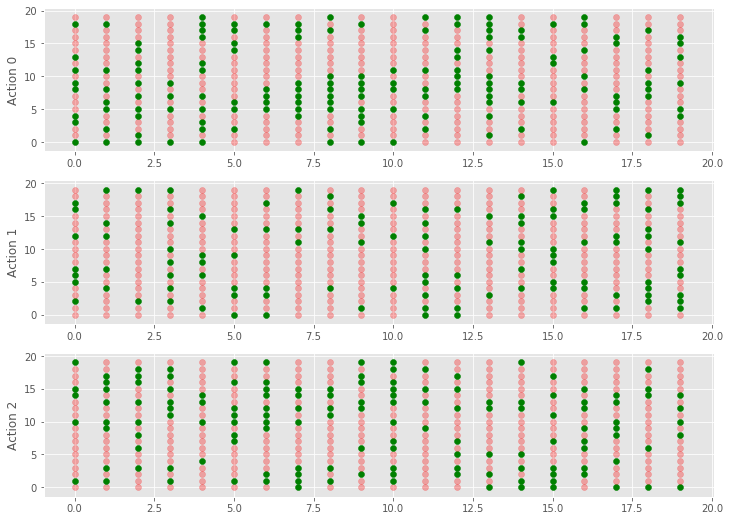

In [59]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot')


def get_q_color(value, vals):
    if value == max(vals):
        return "green", 1.0
    else:
        return "red", 0.3


fig = plt.figure(figsize=(12, 9))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

i = 240
q_table = np.load(f"qtables/{i}-qtable.npy")


for x, x_vals in enumerate(q_table):
    for y, y_vals in enumerate(x_vals):
        ax1.scatter(x, y, c=get_q_color(y_vals[0], y_vals)[0], marker="o", alpha=get_q_color(y_vals[0], y_vals)[1])
        ax2.scatter(x, y, c=get_q_color(y_vals[1], y_vals)[0], marker="o", alpha=get_q_color(y_vals[1], y_vals)[1])
        ax3.scatter(x, y, c=get_q_color(y_vals[2], y_vals)[0], marker="o", alpha=get_q_color(y_vals[2], y_vals)[1])

        ax1.set_ylabel("Action 0")
        ax2.set_ylabel("Action 1")
        ax3.set_ylabel("Action 2")


plt.show()

# Q_table video

## plotting all Q_tables for video

In [61]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot')


def get_q_color(value, vals):
    if value == max(vals):
        return "green", 1.0
    else:
        return "red", 0.3


fig = plt.figure(figsize=(12, 9))


for i in range(0, 25000, 20):
    print(i)
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    q_table = np.load(f"qtables/{i}-qtable.npy")

    for x, x_vals in enumerate(q_table):
        for y, y_vals in enumerate(x_vals):
            ax1.scatter(x, y, c=get_q_color(y_vals[0], y_vals)[0], marker="o", alpha=get_q_color(y_vals[0], y_vals)[1])
            ax2.scatter(x, y, c=get_q_color(y_vals[1], y_vals)[0], marker="o", alpha=get_q_color(y_vals[1], y_vals)[1])
            ax3.scatter(x, y, c=get_q_color(y_vals[2], y_vals)[0], marker="o", alpha=get_q_color(y_vals[2], y_vals)[1])

            ax1.set_ylabel("Action 0")
            ax2.set_ylabel("Action 1")
            ax3.set_ylabel("Action 2")

    #plt.show()
    plt.savefig(f"qtable_charts/{i}.png")
    plt.clf()

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640
3660
3680
3700
3720
3740
3760
3780
3800
3820
3840
3860
3880
3900
3920
3940
3960
3980
4000
4020
4040
4060
4080
4100
4120
4140
4160
4180
4200
4

<Figure size 864x648 with 0 Axes>

## Making the video

In [62]:
import cv2
import os


def make_video():
    # windows:
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    # Linux:
    #fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    out = cv2.VideoWriter('qlearn.avi', fourcc, 20.0, (1200, 900))

    for i in range(0, 14000, 10):
        img_path = f"qtable_charts/{i}.png"
        print(img_path)
        frame = cv2.imread(img_path)
        out.write(frame)

    out.release()


make_video()

qtable_charts/0.png
qtable_charts/10.png
qtable_charts/20.png
qtable_charts/30.png
qtable_charts/40.png
qtable_charts/50.png
qtable_charts/60.png
qtable_charts/70.png
qtable_charts/80.png
qtable_charts/90.png
qtable_charts/100.png
qtable_charts/110.png
qtable_charts/120.png
qtable_charts/130.png
qtable_charts/140.png
qtable_charts/150.png
qtable_charts/160.png
qtable_charts/170.png
qtable_charts/180.png
qtable_charts/190.png
qtable_charts/200.png
qtable_charts/210.png
qtable_charts/220.png
qtable_charts/230.png
qtable_charts/240.png
qtable_charts/250.png
qtable_charts/260.png
qtable_charts/270.png
qtable_charts/280.png
qtable_charts/290.png
qtable_charts/300.png
qtable_charts/310.png
qtable_charts/320.png
qtable_charts/330.png
qtable_charts/340.png
qtable_charts/350.png
qtable_charts/360.png
qtable_charts/370.png
qtable_charts/380.png
qtable_charts/390.png
qtable_charts/400.png
qtable_charts/410.png
qtable_charts/420.png
qtable_charts/430.png
qtable_charts/440.png
qtable_charts/450.png

In [67]:
img_array = []
for filename in glob.glob('qtable_charts/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    img_array.append(img)
size = (width,height)

out = cv2.VideoWriter('outvfvfvfvput.mkv',cv2.VideoWriter_fourcc(*'DIVX'), 45, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()